# Your own few-shot classification model ready in 15mn with PyTorch

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sicara/easy-few-shot-learning/blob/master/notebooks/my_first_few_shot_classifier.ipynb)

I have been working on few-shot classification for a while now. The more I talk about it, the more the people around me seem to feel that it's some kind of dark magic. Even sadder: I noticed that very few actually used it on their projects. I think that's too bad, so I decided to make a tutorial so you'll have no excuse to deprive yourself of the power of few-shot learning methods.

In 15 minutes and just a few lines of code, we are going to implement
the [Prototypical Networks](https://arxiv.org/abs/1703.05175). It's the favorite method of
many few-shot learning researchers (~2000 citations in 3 years), because 1) it works well,
and 2) it's incredibly easy to grasp and to implement.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Dec 20 08:32:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!gdown --id 1YuzCW6s56tV409JRXaAMKFdIkK9xIACw --output "data.zip"
!unzip -q "data.zip"

Downloading...
From: https://drive.google.com/uc?id=1YuzCW6s56tV409JRXaAMKFdIkK9xIACw
To: /content/data.zip
100% 1.13G/1.13G [00:05<00:00, 201MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import sys
import argparse

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import Sampler

import csv
import random
import numpy as np
import pandas as pd

from PIL import Image

## Discovering Prototypical Networks
First, let's install the [tutorial GitHub repository](https://github.com/sicara/easy-few-shot-learning) and import some packages. If you're on Colab right now, you should also check that you're using a GPU (Edit > Notebook settings).

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm

# from easyfsl.data_tools import TaskSampler
# from easyfsl.utils import plot_images, sliding_average

In [ ]:
# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(SEED)
np.random.seed(SEED)

# **Sampler,plot_images, sliding_average**

In [ ]:
from typing import List, Tuple

import torchvision
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn

class GeneratorSampler(Sampler):
    def __init__(self, episode_file_path):
        episode_df = pd.read_csv(episode_file_path).set_index("episode_id")
        self.sampled_sequence = episode_df.values.flatten().tolist()

    def __iter__(self):
        return iter(self.sampled_sequence) 

    def __len__(self):
        return len(self.sampled_sequence)


def plot_images(images: torch.Tensor, title: str, images_per_row: int):
    """
    Plot images in a grid.
    Args:
        images: 4D mini-batch Tensor of shape (B x C x H x W)
        title: title of the figure to plot
        images_per_row: number of images in each row of the grid
    """
    plt.figure()
    plt.title(title)
    plt.imshow(
        torchvision.utils.make_grid(images, nrow=images_per_row).permute(1, 2, 0)
    )


def sliding_average(value_list: List[float], window: int) -> float:
    """
    Computes the average of the latest instances in a list
    Args:
        value_list: input list of floats (can't be empty)
        window: number of instances to take into account. If value is 0 or greater than
            the length of value_list, all instances will be taken into account.
    Returns:
        average of the last window instances in value_list
    Raises:
        ValueError: if the input list is empty
    """
    if len(value_list) == 0:
        raise ValueError("Cannot perform sliding average on an empty list.")
    return np.asarray(value_list[-window:]).mean()

In [ ]:
import random
from typing import List, Tuple

import torch
from torch.utils.data import Sampler, Dataset


class TaskSampler(Sampler):
    """
    Samples batches in the shape of few-shot classification tasks. At each iteration, it will sample
    n_way classes, and then sample support and query images from these classes.
    """

    def __init__(
        self, dataset: Dataset, n_way: int, n_shot: int, n_query: int, n_tasks: int
    ):
        """
        Args:
            dataset: dataset from which to sample classification tasks. Must have a field 'label': a
                list of length len(dataset) containing containing the labels of all images.
            n_way: number of classes in one task
            n_shot: number of support images for each class in one task
            n_query: number of query images for each class in one task
            n_tasks: number of tasks to sample
        """
        super().__init__(data_source=None)
        self.n_way = n_way
        self.n_shot = n_shot
        self.n_query = n_query
        self.n_tasks = n_tasks

        self.items_per_label = {}
        assert hasattr(
            dataset, "labels"
        ), "TaskSampler needs a dataset with a field 'label' containing the labels of all images."
        for item, label in enumerate(dataset.labels):
            if label in self.items_per_label.keys():
                self.items_per_label[label].append(item)
            else:
                self.items_per_label[label] = [item]

    def __len__(self):
        return self.n_tasks

    def __iter__(self):
        for _ in range(self.n_tasks):
            yield torch.cat(
                [
                    # pylint: disable=not-callable
                    torch.tensor(
                        random.sample(
                            self.items_per_label[label], self.n_shot + self.n_query
                        )
                    )
                    # pylint: enable=not-callable
                    for label in random.sample(self.items_per_label.keys(), self.n_way)
                ]
            )

    def episodic_collate_fn(
        self, input_data: List[Tuple[torch.Tensor, int]]
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, List[int]]:
        """
        Collate function to be used as argument for the collate_fn parameter of episodic
            data loaders.
        Args:
            input_data: each element is a tuple containing:
                - an image as a torch Tensor
                - the label of this image
        Returns:
            tuple(Tensor, Tensor, Tensor, Tensor, list[int]): respectively:
                - support images,
                - their labels,
                - query images,
                - their labels,
                - the dataset class ids of the class sampled in the episode
        """

        true_class_ids = list({x[1] for x in input_data})

        all_images = torch.cat([x[0].unsqueeze(0) for x in input_data])
        all_images = all_images.reshape(
            (self.n_way, self.n_shot + self.n_query, *all_images.shape[1:])
        )
        # pylint: disable=not-callable
        all_labels = torch.tensor(
            [true_class_ids.index(x[1]) for x in input_data]
        ).reshape((self.n_way, self.n_shot + self.n_query))
        # pylint: enable=not-callable

        support_images = all_images[:, : self.n_shot].reshape(
            (-1, *all_images.shape[2:])
        )
        query_images = all_images[:, self.n_shot :].reshape((-1, *all_images.shape[2:]))
        support_labels = all_labels[:, : self.n_shot].flatten()
        query_labels = all_labels[:, self.n_shot :].flatten()

        return (
            support_images,
            support_labels,
            query_images,
            query_labels,
            true_class_ids,
        )

# **Dataset**

In [ ]:
filenameToPILImage = lambda x: Image.open(x)

class MiniDataset(Dataset):
    def __init__(self, csv_path, data_dir):
        self.data_dir = data_dir
        self.data_df = pd.read_csv(csv_path).set_index("id")

        self.transform = transforms.Compose([
            filenameToPILImage,
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        self.labels = []

    def __getitem__(self, index):
        path = self.data_df.loc[index, "filename"]
        label = self.data_df.loc[index, "label"]
        image = self.transform(os.path.join(self.data_dir, path))
        return image, label
        
    def __len__(self):
        return len(self.data_df)

In [ ]:
test_set = MiniDataset('/content/hw4_data/mini/val.csv', '/content/hw4_data/mini/val')
train_set = MiniDataset('/content/hw4_data/mini/train.csv', '/content/hw4_data/mini/train')

In [ ]:
for i in range(len(test_set)):
    img, label = test_set[i]
    test_set.labels.append(label)
print(test_set.labels)

for i in range(len(train_set)):
    img, label = train_set[i]
    train_set.labels.append(label)
# print(train_set.labels)

['n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672', 'n01855672'

Let's take some time to grasp what few-shot classification is. Simply put, in a few-shot classification task, you have a labeled support set (which kind of acts
like a catalog) and query set. For each image of the query set, we want to predict a label from the
labels present in the support set. A few-shot classification model has to use the information from the
support set in order to classify query images. We say *few-shot* when the support set contains very
few images for each label (typically less than 10). The figure below shows a 3-way 2-shots classification task. "3-way" means "3 different classes" and "2-shots" means "2 examples per class".
We expect a model that has never seen any Saint-Bernard, Pug or Labrador during its training to successfully
predict the query labels. The support set is the only information that the model has regarding what a Saint-Bernard,
a Pug or a Labrador can be.

![few-shot classification task](https://images.ctfassets.net/be04ylp8y0qc/bZhboqYXfYeW4I88xmMNv/7c5efdc368206feaad045c674b1ced95/1_AteD0yXLkQ1BbjQTB3Ytwg.png?fm=webp)

Most few-shot classification methods are *metric-based*. It works in two phases : 1) they use a CNN to project both
support and query images into a feature space, and 2) they classify query images by comparing them to support images.
If, in the feature space, an image is closer to pugs than it is to labradors and Saint-Bernards, we will guess that
it's a pug.

From there, we have two challenges :

1. Find the good feature space. This is what convolutional networks are for. A CNN is basically a function that takes an image as input and outputs a representation (or *embedding*) of this image in a given feature space. The challenge here is to have a CNN that will
project images of the same class into representations that are close to each other, even if it has not been trained
on objects of this class.
2. Find a good way to compare the representations in the feature space. This is the job of Prototypical Networks.


![Prototypical classification](https://images.ctfassets.net/be04ylp8y0qc/45M9UcUp6KnzwDaBHeGZb7/bb2dcda5942ee7320600125ac2310af6/0_M0GSRZri859fGo48.png?fm=webp)

From the support set, Prototypical Networks compute a prototype for each class, which is the mean of all embeddings
of support images from this class. Then, each query is simply classified as the nearest prototype in the feature space,
with respect to euclidean distance.

If you want to learn more about how this works, I explain it
[there](https://www.sicara.ai/blog/2019-07-30-image-classification-few-shot-meta-learning-5fd736a6c54d2).
But now, let's get to coding.
In the code below (modified from [this](https://github.com/sicara/easy-few-shot-learning/blob/master/easyfsl/methods/prototypical_networks.py)), we simply define Prototypical Networks as a torch module, with a `forward()` method.
You may notice 2 things.

1. We initiate `PrototypicalNetworks` with a *backbone*. This is the feature extractor we were talking about.
Here, we use as backbone a ResNet18 pretrained on ImageNet, with its head chopped off and replaced by a `Flatten`
layer. The output of the backbone, for an input image, will be a 512-dimensional feature vector.
2. The forward method doesn't only take one input tensor, but 3: in order to predict the labels of query images,
we also need support images and labels as inputs of the model.

In [ ]:
import torch.nn as nn

class Convnet(nn.Module):
  def __init__(self, in_channels=3, hid_channels=64, out_channels=64):
    super().__init__()
    self.encoder = nn.Sequential(
        conv_block(in_channels, hid_channels),
        conv_block(hid_channels, hid_channels),
        conv_block(hid_channels, hid_channels),
        conv_block(hid_channels, out_channels),
    )
  def forward(self, x):
    x = self.encoder(x)
    return x.view(x.size(0), -1)

def conv_block(in_channels, out_channels):
  bn = nn.BatchNorm2d(out_channels)
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, 3, padding=1),
      bn,
      nn.ReLU(),
      nn.MaxPool2d(2)
  )

In [ ]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        # Extract the features of support and query images
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Infer the number of different classes from the labels of the support set
        n_way = len(torch.unique(support_labels))
        # Prototype i is the mean of all instances of features corresponding to labels == i
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        # Compute the euclidean distance from queries to prototypes
        dists = torch.cdist(z_query, z_proto)

        # And here is the super complicated operation to transform those distances into classification scores!
        scores = -dists
        return scores


# convolutional_network = resnet18(pretrained=True)
convolutional_network = Convnet()
convolutional_network.fc = nn.Flatten()
print(convolutional_network)

model = PrototypicalNetworks(convolutional_network).cuda()


Convnet(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), str

Now we have a model! Note that we used a pretrained feature extractor,
so our model should already be up and running. Let's see that.

Here we create a dataloader that will feed few-shot classification tasks to our model.
But a regular PyTorch dataloader will feed batches of images, with no consideration for
their label or whether they are support or query. We need 2 specific features in our case.

1. We need images evenly distributed between a given number of classes.
2. We need them split between support and query sets.

For the first point, I wrote a custom sampler: it first samples `n_way` classes from the dataset,
then it samples `n_shot + n_query` images for each class (for a total of `n_way * (n_shot + n_query)`
images in each batch).
For the second point, I have a custom collate function to replace the built-in PyTorch `collate_fn`.
This baby feed each batch as the combination of 5 items:

1. support images
2. support labels between 0 and `n_way`
3. query images
4. query labels between 0 and `n_way`
5. a mapping of each label in `range(n_way)` to its true class id in the dataset
(it's not used by the model but it's very useful for us to know what the true class is)

You can see that in PyTorch, a DataLoader is basically the combination of a sampler, a dataset and a collate function
(and some multiprocessing voodoo): sampler says which items to fetch, the dataset says how to fetch them, and
the collate function says how to present these items together. If you want to dive into these custom objects,
they're [here](https://github.com/sicara/easy-few-shot-learning/tree/master/easyfsl/data_tools).

In [ ]:
N_way = 5 # Number of classes in a task
N_shot = 1 # Number of images per class in the support set
N_query = 15 # Number of images per class in the query set
testcase_csv = '/content/hw4_data/mini/val_testcase.csv'

def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [ ]:

N_EVALUATION_TASKS = 100

test_sampler = TaskSampler(
    test_set, n_way=N_way, n_shot=N_shot, n_query=N_query, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
for i, a in enumerate(test_loader):
  print(a)

(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)

In [ ]:
test_loader = DataLoader(
    test_set, batch_size=N_way * (N_query + N_shot),
    num_workers=3, pin_memory=False, worker_init_fn=worker_init_fn,
    sampler=GeneratorSampler(testcase_csv))

In [ ]:
(
  data,
  target,
) = next(iter(test_loader))
support_input = data[:N_way * N_shot,:,:,:] 
query_input   = data[N_way * N_shot:,:,:,:]

# create the relative label (0 ~ N_way-1) for query data
label_encoder = {target[i * N_shot] : i for i in range(N_way)}
support_label = torch.tensor([0, 1, 2, 3, 4])
query_label = torch.cuda.LongTensor([label_encoder[class_name] for class_name in target[N_way * N_shot:]])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
for i, (data, target) in enumerate(test_loader):

  # split data into support and query data
  support_input = data[:N_way * N_shot,:,:,:] 
  query_input   = data[N_way * N_shot:,:,:,:]

  # create the relative label (0 ~ N_way-1) for query data
  label_encoder = {target[i * N_shot] : i for i in range(N_way)}
  support_label = torch.tensor([0, 1, 2, 3, 4])
  query_label = torch.cuda.LongTensor([label_encoder[class_name] for class_name in target[N_way * N_shot:]])
  print(set(target[N_way * N_shot:]))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'n02950826', 'n02174001', 'n02981792', 'n03535780', 'n01855672'}
{'n02981792', 'n03417042', 'n02138441', 'n01855672', 'n03584254'}
{'n02950826', 'n02138441', 'n01855672', 'n03075370', 'n03584254'}
{'n09256479', 'n02114548', 'n02091244', 'n02138441', 'n03075370'}
{'n02950826', 'n03770439', 'n03535780', 'n03075370', 'n02971356'}
{'n09256479', 'n03770439', 'n03417042', 'n02138441', 'n03075370'}
{'n02114548', 'n03770439', 'n03535780', 'n01855672', 'n02971356'}
{'n09256479', 'n02138441', 'n01855672', 'n03980874', 'n03584254'}
{'n09256479', 'n02981792', 'n03535780', 'n01855672', 'n03584254'}
{'n02950826', 'n03535780', 'n02138441', 'n03584254', 'n02971356'}
{'n09256479', 'n03417042', 'n03535780', 'n01855672', 'n03075370'}
{'n02091244', 'n03770439', 'n02174001', 'n01855672', 'n03980874'}
{'n02091244', 'n03417042', 'n02138441', 'n03075370', 'n03584254'}
{'n02091244', 'n02981792', 'n03773504', 'n02138441', 'n02971356'}
{'n02114548', 'n02091244', 'n02174001', 'n03584254', 'n02971356'}
{'n0209124

In [ ]:
print(set(target[N_way * N_shot:]))

{'n09256479', 'n02950826', 'n03417042', 'n03773504', 'n03535780'}


In [ ]:
print(support_input.shape)
print(query_input.shape)
print(label_encoder)
print(support_label)
print(query_label)

torch.Size([5, 3, 84, 84])
torch.Size([75, 3, 84, 84])
{'n02950826': 0, 'n03417042': 1, 'n03535780': 2, 'n03773504': 3, 'n09256479': 4}
tensor([0, 1, 2, 3, 4])
tensor([0, 0, 2, 3, 3, 3, 1, 3, 1, 4, 3, 2, 3, 2, 0, 2, 0, 3, 1, 2, 2, 2, 4, 2,
        3, 2, 4, 1, 1, 4, 0, 0, 4, 2, 4, 3, 3, 4, 3, 0, 2, 0, 0, 0, 4, 0, 3, 2,
        1, 2, 4, 4, 0, 3, 3, 1, 4, 1, 1, 4, 3, 1, 2, 4, 4, 1, 4, 1, 0, 0, 2, 0,
        1, 1, 1], device='cuda:0')


We created a dataloader that will feed us with 5-way 5-shot tasks (the most common setting in the litterature).
Now, as every data scientist should do before launching opaque training scripts,
let's take a look at our dataset.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


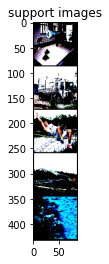

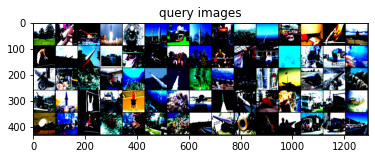

In [ ]:
# (
#     example_support_images,
#     example_support_labels,
#     example_query_images,
#     example_query_labels,
#     example_class_ids,
# ) = next(iter(test_loader))

plot_images(support_input, "support images", images_per_row=N_shot)
plot_images(query_input, "query images", images_per_row=N_query)


For both support and query set, you should have one line for each class.

How does our model perform on this task?

In [ ]:
model.eval()
example_scores = model(
    support_input.cuda(),
    support_label.cuda(),
    query_input.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(query_label)):
    print(
        f"{query_label[i]} / {example_predicted_labels[i]}"
    )

count = 0
for i in range(len(query_label)):
  if query_label[i] == example_predicted_labels[i]:
    count+=1
print(count/75)


Ground Truth / Predicted
0 / 3
0 / 1
2 / 3
3 / 1
3 / 3
3 / 1
1 / 3
3 / 1
1 / 3
4 / 3
3 / 4
2 / 2
3 / 3
2 / 2
0 / 3
2 / 4
0 / 3
3 / 1
1 / 3
2 / 3
2 / 2
2 / 3
4 / 4
2 / 3
3 / 1
2 / 3
4 / 4
1 / 1
1 / 3
4 / 1
0 / 3
0 / 2
4 / 4
2 / 3
4 / 4
3 / 4
3 / 1
4 / 4
3 / 3
0 / 1
2 / 1
0 / 1
0 / 3
0 / 1
4 / 4
0 / 3
3 / 1
2 / 2
1 / 3
2 / 3
4 / 4
4 / 1
0 / 3
3 / 4
3 / 2
1 / 2
4 / 2
1 / 3
1 / 3
4 / 3
3 / 3
1 / 3
2 / 1
4 / 2
4 / 4
1 / 3
4 / 4
1 / 3
0 / 3
0 / 3
2 / 1
0 / 3
1 / 3
1 / 1
1 / 3
0.25333333333333335


This doesn't look bad: keep in mind that the model was trained on very different images, and has only seen 5 examples for each class!

Now that we have a first idea, let's see more precisely how good our model is.

In [ ]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/600 [00:00<?, ?it/s]


ValueError: ignored

With absolutely zero training on Omniglot images, and only 5 examples per class, we achieve around 86% accuracy! Isn't this a great start?

Now that you know how to make Prototypical Networks work, you can see what happens if you tweak it
a little bit (change the backbone, use other distances than euclidean...) or if you change the problem
(more classes in each task, less or more examples in the support set, maybe even one example only,
but keep in mind that in that case Prototypical Networks are just standard nearest neighbour).

When you're done, you can scroll further down and learn how to **meta-train this model**, to get even better results.

## Training a meta-learning algorithm

Let's use the "background" images of Omniglot as training set. Here we prepare a data loader of 40 000 few-shot classification
tasks on which we will train our model. The alphabets used in the training set are entirely separated from those used in the testing set.
This guarantees that at test time, the model will have to classify characters that were not seen during training.

Note that we don't set a validation set here to keep this notebook concise,
but keep in mind that **this is not good practice** and you should always use validation when training a model for production.

We will keep the same model. So our weights will be pre-trained on ImageNet. If you want to start a training from scratch,
feel free to set `pretrained=False` in the definition of the ResNet.

Here we define our loss and our optimizer (cross entropy and Adam, pretty standard), and a `fit` method.
This method takes a classification task as input (support set and query set). It predicts the labels of the query set
based on the information from the support set; then it compares the predicted labels to ground truth query labels,
and this gives us a loss value. Then it uses this loss to update the parameters of the model. This is a *meta-training loop*.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()


To train the model, we are just going to iterate over a large number of randomly generated few-shot classification tasks,
and let the `fit` method update our model after each task. This is called **episodic training**.

This took me 20mn on an RTX 2080 and I promised you that this whole tutorial would take 15mn.
So if you don't want to run the training yourself, you can just skip the training and load the model that I trained
using the exact same code.

In [ ]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
train_csv = '/content/hw4_data/mini/train.csv'

train_loader = DataLoader(
    train_set, batch_size=N_way * (N_query + N_shot),
    num_workers=3, pin_memory=False, worker_init_fn=worker_init_fn,
    sampler=GeneratorSampler(testcase_csv))

with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for i, (data, target) in tqdm_train:

      # split data into support and query data
      support_input = data[:N_way * N_shot,:,:,:] 
      query_input   = data[N_way * N_shot:,:,:,:]

      # create the relative label (0 ~ N_way-1) for query data
      label_encoder = {target[i * N_shot] : i for i in range(N_way)}
      support_label = torch.tensor([0, 1, 2, 3, 4])
      query_label = torch.cuda.LongTensor([label_encoder[class_name] for class_name in target[N_way * N_shot:]])
      
      loss_value = fit(support_input, support_label, query_input, query_label)
      all_loss.append(loss_value)

      if i % log_update_frequency == 0:
          tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))


# with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
#     for episode_index, (
#         support_images,
#         support_labels,
#         query_images,
#         query_labels,
#         _,
#     ) in tqdm_train:
#         loss_value = fit(support_images, support_labels, query_images, query_labels)
#         all_loss.append(loss_value)

#         if episode_index % log_update_frequency == 0:
#             tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 600/600 [00:32<00:00, 18.25it/s, loss=1.04]


In [ ]:
model.eval()
example_scores = model(
    support_input.cuda(),
    support_label.cuda(),
    query_input.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(query_label)):
    print(
        f"{query_label[i]} / {example_predicted_labels[i]}"
    )

count = 0
for i in range(len(query_label)):
  if query_label[i] == example_predicted_labels[i]:
    count+=1
print(count/75*100,'%')

Ground Truth / Predicted
0 / 0
0 / 0
2 / 2
3 / 2
3 / 3
3 / 4
1 / 1
3 / 2
1 / 0
4 / 2
3 / 3
2 / 2
3 / 1
2 / 4
0 / 0
2 / 2
0 / 0
3 / 4
1 / 4
2 / 0
2 / 4
2 / 1
4 / 4
2 / 1
3 / 3
2 / 2
4 / 4
1 / 1
1 / 1
4 / 0
0 / 0
0 / 0
4 / 4
2 / 0
4 / 1
3 / 2
3 / 2
4 / 3
3 / 3
0 / 0
2 / 2
0 / 0
0 / 0
0 / 0
4 / 3
0 / 0
3 / 1
2 / 4
1 / 1
2 / 4
4 / 2
4 / 4
0 / 0
3 / 4
3 / 2
1 / 0
4 / 2
1 / 1
1 / 0
4 / 2
3 / 1
1 / 0
2 / 2
4 / 2
4 / 1
1 / 0
4 / 3
1 / 1
0 / 0
0 / 0
2 / 4
0 / 0
1 / 1
1 / 1
1 / 1
50.66666666666667 %


In [ ]:
evaluate(test_loader)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 100/100 [00:03<00:00, 26.49it/s]

Model tested on 100 tasks. Accuracy: 99.24%


Around 98%!

It's not surprising that the model performs better after being further trained on Omniglot images than it was with its
ImageNet-based parameters. However, we have to keep in mind that the classes on which we just evaluated our model were still
**not seen during training**, so 99% (with a 12% improvement over the model trained on ImageNet) seems like a decent performance.

## What have we learned?

- What a Prototypical Network is and how to implement one in 15 lines of code.
- How to use Omniglot to evaluate few-shot models
- How to use custom PyTorch objets to sample batches in the shape of a few-shot classification tasks.
- How to use meta-learning to train a few-shot algorithm.

## What's next?

- Take this notebook in your own hands, tweak everything that there is to tweak. It's the best way to understand what does what.
- Implement other few-shot learning methods, such as Matching Networks, Relation Networks, MAML...
- Try other ways of training. Episodic training is not the only way to train a model to generalize to new classes!
- Experiment on other, more challenging few-shot learning benchmarks, such as [CUB](http://www.vision.caltech.edu/visipedia/CUB-200.html)
or [Meta-Dataset](https://github.com/google-research/meta-dataset).
- If you liked this tutorial, feel free to ⭐ [give us a star on Github](https://github.com/sicara/easy-few-shot-learning) ⭐
- **Contribute!** The companion repository of this notebook is meant to become a boilerplate, a source of useful code that
that newcomers can use to start their few-shot learning projects.